In this task, you should train a CNN model with pytorch to classify CIFAR10 dataset.

# Load the dataset

Load the CIFAR10 dataset bellow. You can use either `torchvision.datasets.CIFAR10` or `sklearn.datasets.fetch_openml()` or any other way to load the dataset.

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform_compose = transforms.Compose([
    transforms.ToTensor(),
])

cifar_dataset = datasets.CIFAR10(root='dataset', train=True, download=True, transform=transform_compose)
train_size = int(0.9 * len(cifar_dataset))
val_size = len(cifar_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(cifar_dataset, (train_size, val_size))

test_dataset = datasets.CIFAR10(root='dataset', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


# Design your model

Write your CNN model below using `torch.nn` modules. Feel free to add extra cells.

In [11]:
def block1(x, y):
  return nn.Sequential(*[nn.Conv2d(x, y, kernel_size=3, padding=1), 
              nn.BatchNorm2d(y), 
              nn.ReLU(inplace=True), nn.MaxPool2d(2)])

def block2(x, y):
  return nn.Sequential(*[nn.Conv2d(x, y, kernel_size=3, padding=1), 
              nn.BatchNorm2d(y), 
              nn.ReLU(inplace=True)])


class CIFARModel(nn.Module):

  def __init__(self):
      super().__init__()

      self.conv1 = nn.Sequential(block2(3, 64), block1(64, 128))

      self.layer1 = nn.Sequential(block2(128, 128), block2(128, 128))
      
      self.conv2 = nn.Sequential(block1(128, 256), block1(256, 512))
      
      self.layer2 = nn.Sequential(block2(512, 512), block2(512, 512))
      
      self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(), 
                                      nn.Dropout(0.2),
                                      nn.Linear(512, 10))
        
  def forward(self, x):
      x = self.conv1(x)
      x = self.layer1(x) + x
      x = self.conv2(x)
      x = self.layer2(x) + x
      x = self.classifier(x)
      return x

In [12]:
model = CIFARModel().to(device)
model

CIFARModel(
  (conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

# Train your model

Write the training process below. Instantiate your model, Create an optimizer function such as Adam or SGD, and write your train/validation loop. Then train your model until it converges. Feel free to add extra cells.

In [13]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
num_epochs = 20

train_loss_arr, val_loss_arr = [], []
train_accuracy, val_accuracy = [], [] 

torch.autograd.set_detect_anomaly(True)
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0

    model.train()

    epoch_all_train = 0
    epoch_true_train = 0
    epoch_accuracy = 0
    epoch_all_val = 0
    epoch_true_val = 0
    n = 0 
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        # x = x.reshape((-1, 784))
        optimizer.zero_grad()
        p = model(x)
        n += len(x)

        batch_loss = criterion(p, y)
        batch_size = p.shape[0]
        train_loss += float(batch_loss.item() * batch_size)

        predictions = p.argmax(-1)
        epoch_all_train += len(predictions)
        epoch_true_train += int((predictions == y).sum())

        batch_loss.backward()

        optimizer.step()
    
    epoch_true_train *= 100.0 / n

  
    n = 0
    model.eval()            
    with torch.no_grad():
      for i, (x, y) in enumerate(val_loader):
        x = x.to(device)
        y = y.to(device)
        # x = x.reshape((-1, 784))
        p = model(x)
        n += len(x)

        batch_loss = criterion(p, y)
        batch_size = p.shape[0]
        val_loss += float(batch_loss.item() * batch_size)

        predictions = p.argmax(-1)
        epoch_all_val += len(predictions)
        epoch_true_val += int((predictions == y).sum())

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    epoch_true_val *= 100.0 / n

    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    train_accuracy.append(epoch_true_train)
    val_accuracy.append(epoch_true_val)

    print(f"[Epoch {epoch}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}\t"
        f"Train Accuracy: {epoch_true_train:.2f}\t"
        f"Validation Accuracy: {epoch_true_val:.2f}")

[Epoch 0]	Train Loss: 1.3169	Validation Loss: 0.8822	Train Accuracy: 54.58	Validation Accuracy: 69.60
[Epoch 1]	Train Loss: 0.8164	Validation Loss: 0.6277	Train Accuracy: 71.74	Validation Accuracy: 78.82
[Epoch 2]	Train Loss: 0.6111	Validation Loss: 0.6129	Train Accuracy: 78.78	Validation Accuracy: 78.90
[Epoch 3]	Train Loss: 0.4763	Validation Loss: 0.6271	Train Accuracy: 83.50	Validation Accuracy: 79.60
[Epoch 4]	Train Loss: 0.3765	Validation Loss: 0.6099	Train Accuracy: 87.16	Validation Accuracy: 79.94
[Epoch 5]	Train Loss: 0.2855	Validation Loss: 0.5606	Train Accuracy: 90.06	Validation Accuracy: 81.28
[Epoch 6]	Train Loss: 0.2200	Validation Loss: 0.4621	Train Accuracy: 92.43	Validation Accuracy: 84.88
[Epoch 7]	Train Loss: 0.1577	Validation Loss: 0.5632	Train Accuracy: 94.54	Validation Accuracy: 82.42
[Epoch 8]	Train Loss: 0.1292	Validation Loss: 0.5933	Train Accuracy: 95.62	Validation Accuracy: 83.06
[Epoch 9]	Train Loss: 0.1016	Validation Loss: 0.4739	Train Accuracy: 96.54	Validat

# Draw the training curves

Draw two diagrams for train and validat
ion, one showing loss of each epoch, and another showing accuracy of each epoch.

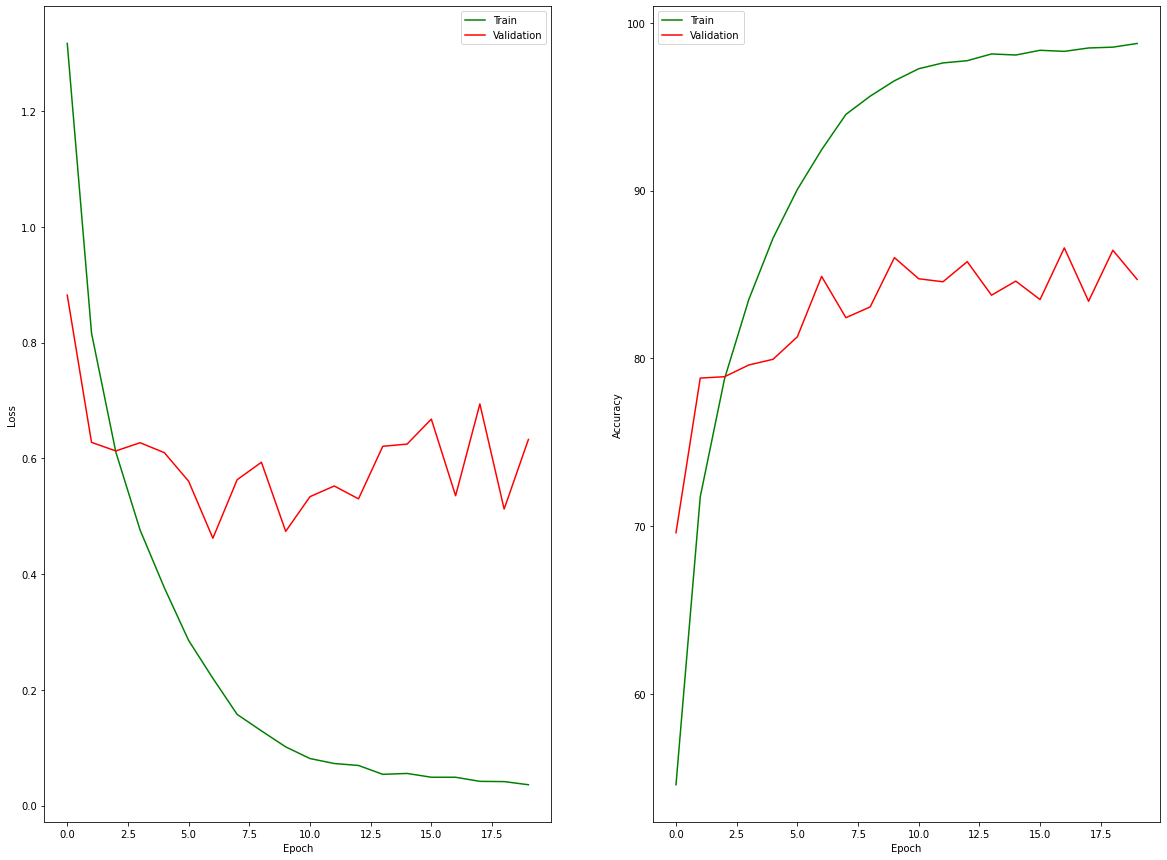

In [15]:
plt.subplot(1, 2, 1)

plt.plot(train_loss_arr,'green',label = 'Train')
plt.plot(val_loss_arr,'red',label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.rcParams["figure.figsize"] = (20,15)


plt.subplot(1, 2, 2)

plt.plot(train_accuracy,'green',label = 'Train')
plt.plot(val_accuracy,'red',label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.rcParams["figure.figsize"] = (20,15)


plt.show()

# Evaluate your model

Evaluate the best epoch's model (according to the validation accuracy) on the test set, and report the accuracy. Is your model overfitted?

In [17]:
model.eval()
accuracy = 0.0
total = 0.0
test_loss = 0
with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      # images = images.reshape((-1, 784))
      outputs = model(images)
      batch_loss = criterion(p, y)
      batch_size = p.shape[0]
      test_loss += float(batch_loss.item() * batch_size)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      accuracy += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")
accuracy = (100 * accuracy / total)
print(f"accuracy: {accuracy:.2f}")

Test Loss: 0.1485
accuracy: 83.82


# Draw misclassified images

Draw 20 misclassified images from test set with expected and predicted labels.

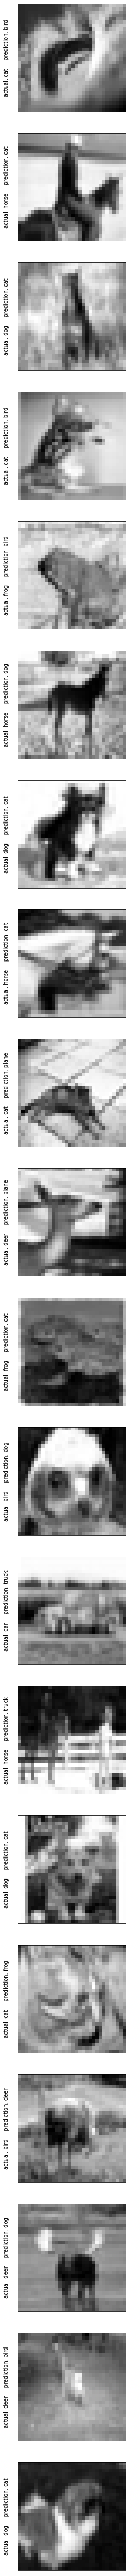

In [22]:
classes = ['plane', 'car', 'bird', 'cat', 
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

batch_size = 32
wrong_images = []
predicted_actual = []
predicted_labels = []
with torch.no_grad():
    for data in test_loader:
      x, labels = data
      images = x.to(device)
      labels = labels.to(device)
      # images = images.reshape((-1, 784))
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      for i in range(len(predicted)):
        p = predicted[i].item()
        l = labels[i].item()
        predicted_labels.append(p)
        if p != l:
          wrong_images.append(x[i])
          predicted_actual.append("actual: " + str(classes[l]) + "     prediction: "+ str(classes[p]))

num_imgs = 20
fig, axs = plt.subplots(num_imgs, 1, figsize=(7, 88))
for i, idx in enumerate(torch.randint(0, len(wrong_images), [num_imgs])):
    x = wrong_images[idx]
    axs[i].imshow(x[0], cmap='gray')
    axs[i].set_ylabel(predicted_actual[idx] + "\n")
    for k in range(1):
        axs[i].set_yticks([])
        axs[i].set_xticks([])

# Plot the confusion matrix

Plot the confusion matrix for the test set.

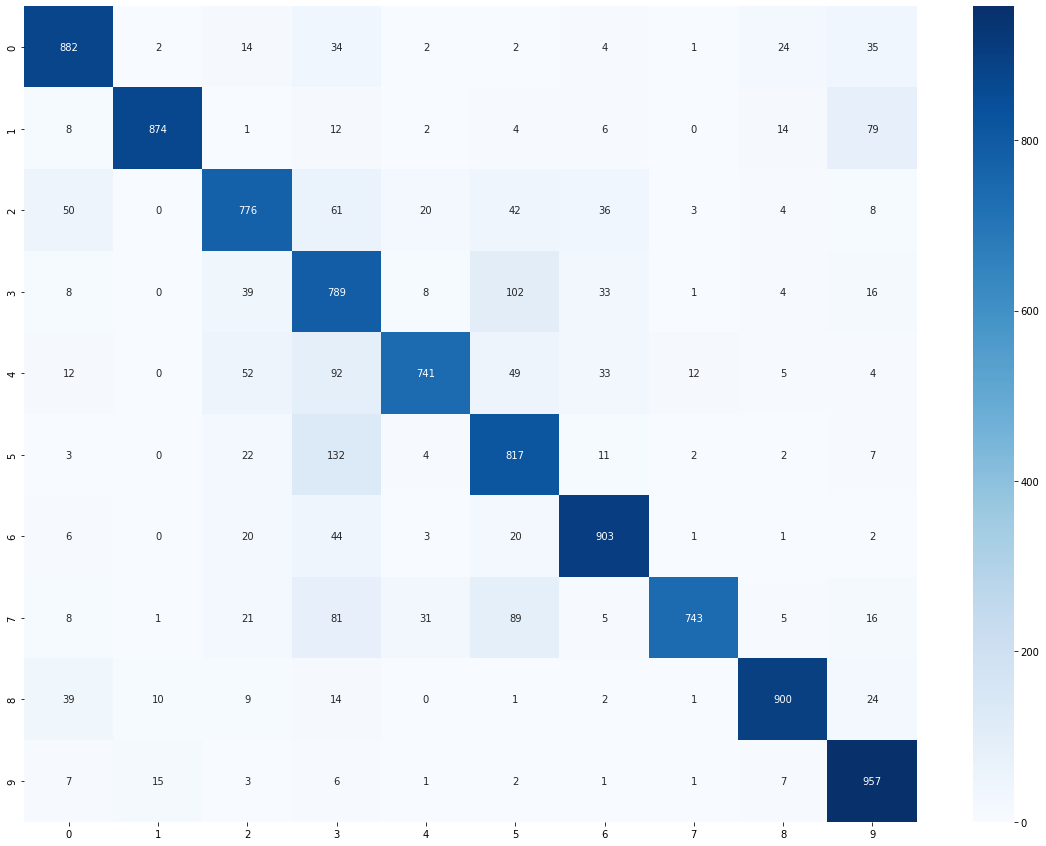

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = [x for _, x in test_loader.dataset]
predicted = [int(x) for x in predicted_labels]
sns.heatmap(confusion_matrix(true_labels, predicted), cmap="Blues", annot=True, fmt='d')